In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, ShuffleSplit, KFold, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, r2_score,  mean_squared_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin


## Load data

In [70]:
for file_name in os.listdir("files"):
    if file_name.endswith('.csv'):
        file_path = os.path.join("files", file_name)

        df_name = os.path.splitext(file_name)[0]
        globals()[df_name] = pd.read_csv(file_path)


## Simplification of categories

In [73]:
# Merge sports data and extract sports categories
def extract_sports_category(dataset, sports_code):
    merged = pd.merge(dataset, sports_code, left_on="Sports", right_on="Code")
    merged["Sports_Category"] = merged["Categorie"]
    return merged[["PRIMARY_KEY", "Sports_Category"]]

learn_sports = extract_sports_category(learn_dataset_sport, code_Sports)
test_sports = extract_sports_category(test_dataset_sport, code_Sports)

# Merge departments into regions and extract relevant region columns
def merge_and_extract_region(df, merge_column, region_column_name):
    merged = pd.merge(df, departments, left_on=merge_column, right_on="DEP")
    merged[region_column_name] = merged["REG"]
    return merged.drop(["Nom du département", "REG", "DEP", merge_column], axis=1)

learn_dataset_job = merge_and_extract_region(learn_dataset_job, "JOB_DEP", "REG_JOB")
learn_dataset_retired_jobs = merge_and_extract_region(learn_dataset_retired_jobs, "JOB_DEP", "REG_JOB")
learn_dataset_retired_jobs = merge_and_extract_region(learn_dataset_retired_jobs, "FORMER_DEP", "REG_FORMER")

test_dataset_job = merge_and_extract_region(test_dataset_job, "JOB_DEP", "REG_JOB")
test_dataset_retired_jobs = merge_and_extract_region(test_dataset_retired_jobs, "JOB_DEP", "REG_JOB")
test_dataset_retired_jobs = merge_and_extract_region(test_dataset_retired_jobs, "FORMER_DEP", "REG_FORMER")


In [74]:
#Economic sector into fewer categories (and numeric instead of object/string)
def sector_mapping(nace_code):
    if nace_code == "AZ":  
        return "Agriculture, forestry and fishing)"
    elif "BZ" <= nace_code <= "EZ":
        return "Manufacturing, mining and quarrying and other industrial activities"
    elif nace_code == "FZ": 
        return "Construction"
    elif "GZ" <= nace_code <= "IZ":  
        return "Wholesale and retail trade, transportation and storage, accommodation and food service activities"
    elif "JA" <= nace_code <= "JC":
        return "Information and communication"
    elif nace_code == "KZ": 
        return "Financial and insurance activities"
    elif nace_code == "LZ": 
        return "Real estate activities"
    elif "MA" <= nace_code <= "NZ":
        return "Professional, scientific, technical, administrative and support service activities"
    elif "OZ" <= nace_code <= "QB":
        return "Public administration and defence, education, human health and social work activities"
    elif "RZ" <= nace_code <= "UZ":
        return "Other services activities"
    else:
        return "Unknown Sector"

code_Economic_sector["Nomenclature"] = code_Economic_sector["Code"].map(sector_mapping)
code_Economic_sector["Economic_sector_num"] = pd.factorize(code_Economic_sector["Nomenclature"])[0] + 1

code_HIGHEST_CREDENTIAL["HIGHEST_CREDENTIAL_num"] = pd.factorize(code_HIGHEST_CREDENTIAL["Code"])[0] + 1
code_act["act_num"] = pd.factorize(code_act["Code"])[0] + 1


## Merging

In [78]:
learn_data = learn_dataset

learn_data = pd.merge(learn_data, code_act, left_on="act", right_on="Code", how="left")
learn_data.drop(["Code", "Libellé"], axis=1, inplace=True)
learn_data = pd.merge(learn_data, code_HIGHEST_CREDENTIAL, left_on="HIGHEST_CREDENTIAL", right_on="Code", how="left")
learn_data.drop(["Code", "Libellé", "HIGHEST_CREDENTIAL"], axis=1, inplace=True)

#for imputation fitting
learn_data = pd.merge(learn_data, city_pop, on="INSEE_CODE", how="left")
learn_data = pd.merge(learn_data, city_loc, on="INSEE_CODE", how="left")


test_data = test_dataset

test_data = pd.merge(test_data, code_act, left_on="act", right_on="Code", how="left")
test_data.drop(["Code", "Libellé"], axis=1, inplace=True)
test_data = pd.merge(test_data, code_HIGHEST_CREDENTIAL, left_on="HIGHEST_CREDENTIAL", right_on="Code", how="left")
test_data.drop(["Code", "Libellé", "HIGHEST_CREDENTIAL"], axis=1, inplace=True)

In [80]:
learn_dfs = [learn_dataset_emp_contract, learn_dataset_job, learn_dataset_retired_former, learn_dataset_retired_jobs, learn_dataset_retired_pension, learn_sports]
test_dfs = [test_dataset_emp_contract, test_dataset_job, test_dataset_retired_former, test_dataset_retired_jobs, test_dataset_retired_pension, test_sports]

for df in learn_dfs:
    learn_data = pd.merge(learn_data, df, on="PRIMARY_KEY", how="outer")

for df in test_dfs:
    test_data = pd.merge(test_data, df, on="PRIMARY_KEY", how="outer")

In [82]:
# Function to combine columns ending with `_x` and `_y` into a single base column
def combine_duplicate_columns(dataframe):
    for column in dataframe.columns:
        if column.endswith('_x'):
            base_column = column[:-2]  # Remove `_x` suffix
            y_column = base_column + '_y'
            if y_column in dataframe.columns:
                # Combine the `_x` and `_y` columns
                dataframe[base_column] = dataframe[column].fillna(dataframe[y_column])
                # Drop the original `_x` and `_y` columns
                dataframe.drop(columns=[column, y_column], inplace=True)
    return dataframe

# Apply the function to both datasets
learn_data = combine_duplicate_columns(learn_data)
test_data = combine_duplicate_columns(test_data)


## Formatting - for Random Forest

In [85]:
def household_num(value):
    parts = value.split('|')  # Split the value by '|'
    if parts[1] in {'1', '2', '3'}:  # For M|1|-- to M|3|--
        return int(parts[1])
    elif parts[1] == '4':  # For M|4|1 to M|4|4
        return 4 + (int(parts[2]) - 1)  # 4 + (1-1), 4 + (2-1), etc.
    return None  # Handle unexpected cases gracefully

In [87]:
code_HOUSEHOLD_TYPE['HOUSEHOLD_TYPE_num'] = code_HOUSEHOLD_TYPE['Code'].apply(household_num)
learn_data['HOUSEHOLD_TYPE'] = learn_data['HOUSEHOLD_TYPE'].apply(household_num)
test_data['HOUSEHOLD_TYPE'] = test_data['HOUSEHOLD_TYPE'].apply(household_num)

In [89]:
#learn_data["JOB_42"] = learn_data["JOB_42"].str.extract(r'csp_(\d)')[0].astype(int)
#learn_data["FORMER_JOB_42"] = learn_data["FORMER_JOB_42"].str.extract(r'csp_(\d)')[0].astype("Int64")

# Function to preprocess dataset
def preprocess_employee_data(data, economic_sector_code, work_description_map):
    # Extract numeric values from specific columns
    data["employee_count"] = data["employee_count"].str.extract(r'tr_(\d)')[0].astype("Int64")
    data["Employer_category"] = data["Employer_category"].str.extract(r'ct_(\d)')[0].astype("Int64")
    
    # Merge with economic sector codes
    data = pd.merge(data, economic_sector_code, left_on="Economic_sector", right_on="Code", how="left")
    
    # Merge with work description map and clean up columns
    data = pd.merge(data, work_description_map, left_on="work_description", right_on="N3", how="left")
    data.drop(["work_description", "N3", "N2"], axis=1, inplace=True)
    data["N1"] = data["N1"].str.extract(r'csp_(\d)')[0].astype("Int64")
    data.rename(columns={"N1": "work_description"}, inplace=True)
    
    # Combine columns for contracts and pay
    data["emp_contract"] = combine_columns(data["emp_contract"], data["former_emp_contract"])
    data["Pay"] = combine_columns(data["Pay"], data["RETIREMENT_PAY"])
    
    return data

# Preprocess both learn and test datasets
learn_data = preprocess_employee_data(learn_data, code_Economic_sector, code_work_description_map)
test_data = preprocess_employee_data(test_data, code_Economic_sector, code_work_description_map)


In [90]:
def categorize_retirement_age(data):
    # Ensure the retirement_age column is numeric
    data['retirement_age'] = pd.to_numeric(data['retirement_age'], errors='coerce')
    
    # Define the bins and corresponding labels
    bins = [0, 57, 60, 61, 63, 65, float('inf')]  # Specify edges for the ranges
    labels = ['<57', '57-59', '60', '61-62', '63-64', '65+']  # Labels for ranges

    # Categorize retirement_age into retirement_age_cat
    data['retirement_age_cat'] = pd.cut(
        data['retirement_age'], 
        bins=bins, 
        labels=labels, 
        right=False,  # Left-closed intervals
        include_lowest=True
    )
    
    # Ensure missing values in retirement_age_cat are handled properly
    data['retirement_age_cat'] = data['retirement_age_cat'].astype(object)  # Avoid ambiguity with NA
    
    # Handle exact matches for 60 and 65
    data.loc[data['retirement_age'] == 60, 'retirement_age_cat'] = '60'

# Apply the function to both datasets
categorize_retirement_age(learn_data)
categorize_retirement_age(test_data)

In [93]:
# Function to preprocess column types
def preprocess_column_types(data):
    data["sex"] = pd.factorize(data["sex"])[0]
    data["studying"] = data["studying"].astype("int64")
    data["Sports_Category"] = data["Sports_Category"].fillna(0).astype("int64")
    
    # List of columns to convert to Int64
    int_columns = ["REG_JOB", "REG_FORMER", "retirement_age", "WORKING_HOURS", "Economic_sector_num", "Pay"]
    
    for col in int_columns:
        data[col] = pd.to_numeric(data[col], errors='coerce').astype('Int64')
    
    return data

# Apply the function to both datasets
learn_data = preprocess_column_types(learn_data)
test_data = preprocess_column_types(test_data)

In [95]:
def replace_na_with_category(data, column_name):
    # Convert the column to categorical
    data[column_name] = data[column_name].astype('category')
    
    # Define categories to add
    additional_categories = ['Unemployed', 'Retired_Missing', 'Employed_Missing']
    
    # Add the specified categories
    data[column_name] = data[column_name].cat.add_categories(additional_categories)
    
    # Assign categories based on conditions
    data.loc[(data[column_name].isna()) & (data['JOB_42'].astype(str).str.startswith('csp_7')), column_name] = 'Retired_Missing'
    data.loc[(data[column_name].isna()) & (data['act_num'] == 1), column_name] = 'Employed_Missing'
    data.loc[(data[column_name].isna()) & ((data['JOB_42'].astype(str).str.startswith('csp_8')) | (data['act_num'] == 2)), column_name] = 'Unemployed'

# List of columns to process
columns_to_process = [
    "emp_contract", "TYPE_OF_CONTRACT", "WORK_CONDITION", 
    "labor_force_status", "Economic_sector_num", "REG_JOB", 
    "REG_FORMER", "work_description", "retirement_age_cat"
]

# Apply the function to each column for both datasets
for column in columns_to_process:
    replace_na_with_category(learn_data, column)
    replace_na_with_category(test_data, column)

In [97]:
def fill_missing_values(data, column, unemployed_value, default_value):
    data[column] = data.apply(
        lambda row: unemployed_value if pd.isna(row[column]) and 
                        (str(row['JOB_42']).startswith('csp_8') or row['act_num'] == 2)  # unemployed
                    else (default_value if pd.isna(row[column]) else row[column]),
        axis=1
    )

# Fill missing values for both datasets
fill_missing_values(learn_data, 'Employer_category', unemployed_value=10, default_value=0)
fill_missing_values(learn_data, 'employee_count', unemployed_value=7, default_value=0)

fill_missing_values(test_data, 'Employer_category', unemployed_value=10, default_value=0)
fill_missing_values(test_data, 'employee_count', unemployed_value=7, default_value=0)

In [98]:
def clean_data(data, drop_columns):
    # Replace JOB_42 with FORMER_JOB_42 where applicable
    data.loc[data['JOB_42'].astype(str).str.startswith('csp_7'), 'JOB_42'] = data['FORMER_JOB_42']
    
    # Fill missing Pay and WORKING_HOURS for unemployed
    data.loc[(data['emp_contract'] == 'Unemployed') & (data['Pay'].isna()), 'Pay'] = 0
    data.loc[(data['emp_contract'] == 'Unemployed') & (data['WORKING_HOURS'].isna()), 'WORKING_HOURS'] = 0
    
    # Drop unnecessary columns
    return data.drop(columns=drop_columns)

# Define columns to drop for each dataset
learn_drop_columns = [
    "act", "former_emp_contract", "RETIREMENT_PAY", "retirement_age", 
    "FORMER_JOB_42", "Economic_sector", "Code", "Libellé", 
    "Nomenclature", "X", "Y"
]

test_drop_columns = [
    "act", "INSEE_CODE", "former_emp_contract", "RETIREMENT_PAY", "retirement_age", 
    "FORMER_JOB_42", "Economic_sector", "Code", "Libellé", 
    "Nomenclature"
]

# Apply the cleaning function
learn_data = clean_data(learn_data, learn_drop_columns)
test_data = clean_data(test_data, test_drop_columns)


# Handling Missing Data

In [102]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)  #% of missing values
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)  #create result table
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

print(missing_values_table(learn_data)) 
print(missing_values_table(test_data)) 

There are 2 columns that have missing values.
               Missing Values  % of Total Values
WORKING_HOURS            7345               14.7
Pay                      6961               13.9
There are 2 columns that have missing values.
               Missing Values  % of Total Values
WORKING_HOURS            7307               14.6
Pay                      6884               13.8


## replacing missing values with mean

Replacement with values using external data for pay and working hours

In [106]:
# Define job-specific pay and working hours
job_defaults = {
    'csp_1': {'Pay': 50000, 'WORKING_HOURS': 2860},  # Agriculture
    'csp_2_1': {'Pay': 24000, 'WORKING_HOURS': 2288},  # Artisans
    'csp_2_2': {'Pay': 39937, 'WORKING_HOURS': 2444},  # Commerçant
    'csp_2_3': {'Pay': 58248, 'WORKING_HOURS': 2704},  # Chefs d'enterprise
}

# Function to fill missing values for Pay and WORKING_HOURS
def fill_job_defaults(data, job_defaults):
    for job, defaults in job_defaults.items():
        # Handle string startswith for specific cases (e.g., 'csp_1')
        job_condition = data['JOB_42'].astype(str).str.startswith(job) if '_' not in job else (data['JOB_42'] == job)
        
        # Fill missing Pay and WORKING_HOURS
        data.loc[job_condition & data['Pay'].isna(), 'Pay'] = defaults['Pay']
        data.loc[job_condition & data['WORKING_HOURS'].isna(), 'WORKING_HOURS'] = defaults['WORKING_HOURS']

# Apply the function to both datasets
fill_job_defaults(learn_data, job_defaults)
fill_job_defaults(test_data, job_defaults)


In [108]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)  #% of missing values
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)  #create result table
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

print(missing_values_table(learn_data)) 
print(missing_values_table(test_data)) 

There are 2 columns that have missing values.
               Missing Values  % of Total Values
WORKING_HOURS            4746                9.5
Pay                      4362                8.7
There are 2 columns that have missing values.
               Missing Values  % of Total Values
WORKING_HOURS            4714                9.4
Pay                      4291                8.6


# Sorting for numeric

In [111]:
# List of columns to factorize
columns_to_factorize = [
    'JOB_42', 'REG_JOB', 'Economic_sector_num', 'work_description', 
    'retirement_age_cat', 'REG_FORMER', 'TYPE_OF_CONTRACT', 
    'WORK_CONDITION', 'labor_force_status', 'emp_contract'
]

# Function to sort and factorize columns
def sort_and_factorize(data, columns):
    for column in columns:
        data = data.sort_values(by=column, ascending=False)
        data[column] = pd.factorize(data[column])[0]
    return data.sort_values(by='PRIMARY_KEY', ascending=True)

# Apply the function to learn_data and test_data
learn_rf = sort_and_factorize(learn_data, columns_to_factorize)
test_rf = sort_and_factorize(test_data, columns_to_factorize)

In [113]:
learn_rf.drop(["Lat", "long", "RESIDENTS", "INSEE_CODE"], axis=1, inplace=True)

## Prediction

In [116]:
x_train = learn_rf.drop(columns=["target"])
y_train = learn_rf["target"]


In [119]:
X_train, X_test, Y_train, Y_test = train_test_split(x_train,
                                                    y_train, 
                                                    test_size=0.3, 
                                                    random_state=42)

In [121]:
# Custom Transformer for Handling Imputation with Averages
class ImputeMissingValues(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # Calculate averages for training data (ignoring zero values)
        self.avg_working_hours = X.loc[X["WORKING_HOURS"] != 0].groupby("JOB_42")["WORKING_HOURS"].mean().round()
        self.avg_pay = X.loc[X["Pay"] != 0].groupby("JOB_42")["Pay"].mean().round()
        return self

    def transform(self, X, y=None):
        # Use the stored averages to impute missing values
        X = X.copy()
        X["WORKING_HOURS"] = X.apply(
            lambda row: self.avg_working_hours.get(row["JOB_42"], np.nan) 
            if pd.isnull(row["WORKING_HOURS"]) else row["WORKING_HOURS"],
            axis=1
        )
        X["Pay"] = X.apply(
            lambda row: self.avg_pay.get(row["JOB_42"], np.nan) 
            if pd.isnull(row["Pay"]) else row["Pay"],
            axis=1
        )
        return X

In [123]:
# Custom Transformer for MICE (Multiple Imputation by Chained Equations) Imputation
class MICEImputer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_impute):
        self.columns_to_impute = columns_to_impute
        self.imputer = IterativeImputer(random_state=100)
        
    def fit(self, X, y=None):
        # Fit the imputer only on the specified columns
        self.imputer.fit(X[self.columns_to_impute])
        return self
    
    def transform(self, X):
        # Transform only the specified columns
        X_imputed = X.copy()
        X_imputed[self.columns_to_impute] = self.imputer.transform(X[self.columns_to_impute])
        return X_imputed

In [125]:
# Specify the columns that need MICE imputation
columns_to_impute = ["Employer_category", "employee_count"]

# Define the combined pipeline
pipeline = Pipeline([
    ('impute_averages', ImputeMissingValues()),  # Step 1: Impute using averages
    ('mice_imputer', MICEImputer(columns_to_impute=columns_to_impute)),  # Step 2: MICE imputation
])

pipeline.fit_transform(X_train, Y_train)

,PRIMARY_KEY,sex,JOB_42,studying,age_2020,HOUSEHOLD_TYPE,act_num,HIGHEST_CREDENTIAL_num,emp_contract,Pay,...,Employer_category,employee_count,TYPE_OF_CONTRACT,WORK_CONDITION,labor_force_status,WORKING_HOURS,REG_JOB,Economic_sector_num,work_description,retirement_age_cat
20410,41175,0,13,0,50,4,1,7,4,21478.0,...,9.0,1.0,5,5,4,1820.0,7,11,4,0
25171,50651,0,1,0,30,3,7,7,0,0.0,...,10.0,7.0,2,2,2,0.0,2,2,2,1
11941,23931,0,18,0,28,4,1,11,4,16837.0,...,9.0,1.0,5,5,4,1540.0,6,5,5,0
3252,6624,1,18,0,67,1,3,6,4,25962.0,...,8.0,5.0,5,5,4,1820.0,9,7,5,6
16420,32956,0,19,0,59,4,1,7,4,17886.0,...,9.0,3.0,5,3,4,1456.0,5,9,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,22614,1,1,1,17,5,4,3,0,0.0,...,10.0,7.0,2,2,2,0.0,2,2,2,1
44732,89529,0,2,1,19,4,4,4,0,0.0,...,10.0,7.0,2,2,2,0.0,2,2,2,1
38158,76518,1,8,0,52,2,2,5,0,0.0,...,10.0,7.0,2,2,2,0.0,2,2,2,1
860,1814,0,19,0,49,3,1,7,4,20998.0,...,3.0,6.0,5,5,4,1820.0,11,4,5,0


In [128]:
param_grid_rf = {     # Number of trees in the forest
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10, 30],    
    'min_samples_split': [5, 10, 20]  
}

# Define cross-validation with 5 folds
cv_folds = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the RandomForestRegressor model
rf = RandomForestRegressor(random_state=42)  #need to add that in the pipeline 

# Set up the GridSearchCV for RandomForestRegressor with appropriate scoring metric
rf_search = GridSearchCV(rf, param_grid_rf, cv=cv_folds, n_jobs=-1, scoring="neg_mean_squared_error")

In [130]:
# Fit the model on the training data
rf_res = rf_search.fit(X_train, Y_train)

In [131]:
# Get the best model after GridSearchCV
best_model_rf = rf_res.best_estimator_

# Output the best model and its score
print(f"Best model: {best_model_rf}")
print(f"Best score: {rf_res.best_score_}")

Best model: RandomForestRegressor(max_depth=30, min_samples_split=5, n_estimators=150,
                      random_state=42)
Best score: -1.1258992290058942


In [132]:
train_predictions = best_model_rf.predict(X_train)
test_predictions = best_model_rf.predict(X_test)

print("R² for training set: ", r2_score(Y_train, train_predictions))
print("R² for test set: ", r2_score(Y_test, test_predictions))
print("RMSE on the learning set:", root_mean_squared_error(Y_train, best_model_rf.predict(X_train)))
print("RMSE on the test set:", root_mean_squared_error(Y_test, best_model_rf.predict(X_test)))

R² for training set:  0.9450027037635332
R² for test set:  0.7457895990349557
RMSE on the learning set: 0.4821260465341749
RMSE on the test set: 1.0425678311890367


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


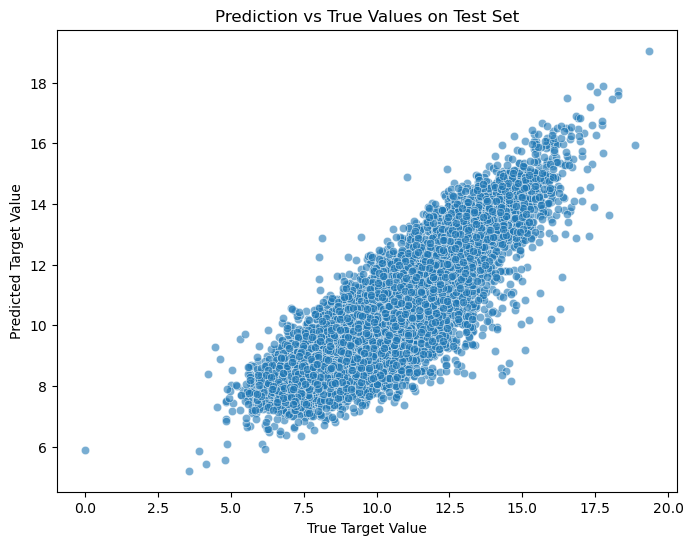

In [133]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=Y_test, y=test_predictions, alpha=0.6)
plt.xlabel('True Target Value')
plt.ylabel('Predicted Target Value')
plt.title('Prediction vs True Values on Test Set')
plt.show()

## Data cleaning - test data

In [137]:
test_rf = pipeline.transform(test_rf)
test_predictions = best_model_rf.predict(test_rf)  # Replace with your model's prediction method

predictions_df = pd.DataFrame({
    'PRIMARY_KEY': test_rf['PRIMARY_KEY'], 
    'target': test_predictions
})

# Save the predictions to a CSV file
predictions_df.to_csv('predictions.csv', index=False, sep=',', float_format='%.6f')  # Save with US decimal notation

In [141]:
hhhhh = pd.read_csv("predictions.csv")
hhhhh


,PRIMARY_KEY,target
0,2,9.904286
1,3,11.988057
2,4,9.413385
3,6,12.637923
4,9,9.303867
...,...,...
50035,100071,9.388498
50036,100074,8.436817
50037,100075,10.219654
50038,100080,12.860356


# Preprocessing - for Regression